# Includes

In [1]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
import multiprocessing
import os.path
import csv
import copy
import joblib
from torchvision import datasets
import torchvision
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("white")
from pdb import set_trace as bp
from torch.optim.lr_scheduler import StepLR

In [2]:
USE_CUDA = torch.cuda.is_available()

def w(v):
    if USE_CUDA:
        return v.cuda()
    return v

In [3]:
from meta_module import *

In [4]:
!mkdir -p _cache
cache = joblib.Memory(location='_cache', verbose=0)

# Hamiltonian

In [ ]:
! pip install git+https://github.com/rtqichen/torchdiffeq
from torchdiffeq import odeint_adjoint as odeint
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

In [60]:
import torch
import torch.nn as nn
import torchdiffeq

class ODEBlock(nn.Module):
    def __init__(self, odefunc:nn.Module, method:str='dopri5', rtol:float=1e-3, atol:float=1e-4, adjoint:bool=True):
        """ Standard ODEBlock class. Can handle all types of ODE functions
            :method:str = {'euler', 'rk4', 'dopri5', 'adams', 'scipy_solver'}
        """
        super().__init__()
        self.odefunc = odefunc
        self.method = method
        self.adjoint_flag = adjoint
        self.atol, self.rtol = atol, rtol

    def forward(self, x:torch.Tensor, T:int=1):
        self.integration_time = torch.tensor([0, T]).float()
        self.integration_time = self.integration_time.type_as(x)

        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, self.integration_time,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                     rtol=self.rtol, atol=self.atol, method=self.method)
        # print(out.shape)
        return out[-1]
    
    def forward_batched(self, x:torch.Tensor, nn:int, indices:list, timestamps:set):
        """ Modified forward for ODE batches with different integration times """
        timestamps = torch.Tensor(list(timestamps))
        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, timestamps,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, timestamps,
                                     rtol=self.rtol, atol=self.atol, method=self.method)

        out = self._build_batch(out, nn, indices).reshape(x.shape)
        return out
    
    def _build_batch(self, odeout, nn, indices):
        b_out = []
        for i in range(len(indices)):
            b_out.append(odeout[indices[i],i*nn:(i+1)*nn])
        return torch.cat(b_out).to(odeout.device)
              
        
    def trajectory(self, x:torch.Tensor, T:int, num_points:int):
        self.integration_time = torch.linspace(0, T, num_points)
        self.integration_time = self.integration_time.type_as(x)
        out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                 rtol=self.rtol, atol=self.atol, method=self.method)
        return out

In [53]:
gdefunc = Hamiltonian(1)
gde = ODEBlock(odefunc=gdefunc)

In [57]:
gde(torch.randn(5, 2))

torch.Size([2, 5, 2])


tensor([[ 0.0471, -0.0245],
        [ 1.0420,  1.7681],
        [-0.4962,  0.8190],
        [-0.4245,  0.2470],
        [-0.5728,  2.1203]], grad_fn=<SelectBackward>)

In [56]:
gde.trajectory(torch.randn(5, 2), T=1, num_points=20).shape

torch.Size([20, 5, 2])

In [78]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Hamiltonian(nn.Module):
    def __init__(self, input_dim:int):
        super().__init__()
        self.input_dim = input_dim
        #self.g = nn.Parameter(torch.rand((int(input_dim)), dtype=torch.float32, requires_grad=True))
        #self.v = nn.Parameter(torch.rand((1), dtype=torch.float32, requires_grad=True))
        self.g = nn.Sequential(nn.Linear(int(input_dim), int(input_dim)), nn.ReLU(), nn.Linear(int(input_dim), 1))
        self.v = nn.Sequential(nn.Linear(int(input_dim), int(input_dim)), nn.ReLU(), nn.Linear(int(input_dim), 1))
        self.D = nn.Linear(2*input_dim, 2*input_dim)
        self.L = nn.Linear(int(input_dim), int(input_dim))
        self.L.weight.data.fill_(0.0)
        self.L.weight.data += torch.eye((int(self.input_dim)), dtype=torch.float32, requires_grad=True)
        self.nfe = 0
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    def forward(self, t, x):
        with torch.enable_grad():
            one = torch.tensor(1, dtype=torch.float32, device=self.device, requires_grad=True)
            x = one * x
            self.nfe += 1
            q, dev_q = torch.chunk(x, 2, dim=-1)
            #print(q)
            g = self.g(q)
            H = self.v(q) + torch.sum(torch.pow(torch.matmul(dev_q, self.L.weight.t()), 2)) / 2.0 
            H = H.reshape(-1,)
            M = torch.matmul(self.L.weight, self.L.weight.t()) + 1e-12*torch.eye((int(self.input_dim)), dtype=torch.float32, device=self.device)
            
            dH_q = torch.autograd.grad(H, q, grad_outputs=torch.ones_like(H), create_graph=True)[0]
            D_q, D_p = torch.chunk(self.D(torch.cat((dH_q, dev_q), dim=-1)), 2, dim=-1)
            out = torch.cat((dev_q-D_q, torch.matmul(-dH_q-D_p+g, M.inverse())), dim=-1).view_as(x)
        return out

In [73]:
class Hamiltonian(nn.Module):
    def __init__(self, input_dim:int):
        """Standard GCDN ODE function class. To be passed to an ODEBlock"""
        super().__init__()
        self.lin1 = nn.Linear(2*input_dim, 20)
        self.act = nn.Tanh()
        self.lin2 = nn.Linear(20, 2)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        x = self.lin1(x)
        x = self.act(x)
        x = self.lin2(x)
        return x

# Funcs

In [26]:
def detach_var(v):
    var = w(Variable(v.data, requires_grad=True))
    var.retain_grad()
    return var

import functools

def rsetattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    return setattr(rgetattr(obj, pre) if pre else obj, post, val)

# using wonder's beautiful simplification: https://stackoverflow.com/questions/31174295/getattr-and-setattr-on-nested-objects/31174427?noredirect=1#comment86638618_31174427

def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))

def do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True):
    if should_train:
        opt_net.train()
    else:
        opt_net.eval()
        unroll = 1
    
    target = target_cls(training=should_train)
    optimizee = w(target_to_opt())
    n_params = 0
    for name, p in optimizee.all_named_parameters():
        n_params += int(np.prod(p.size()))
    hidden_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    cell_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    all_losses_ever = []
    if should_train:
        meta_opt.zero_grad()
    all_losses = None
    for iteration in range(1, optim_it + 1):
        loss = optimizee(target)
                    
        if all_losses is None:
            all_losses = loss
        else:
            all_losses += loss
        
        all_losses_ever.append(loss.data.cpu().numpy())
        loss.backward(retain_graph=should_train)

        offset = 0
        result_params = {}
        hidden_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        cell_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        for name, p in optimizee.all_named_parameters():
            cur_sz = int(np.prod(p.size()))
            # We do this so the gradients are disconnected from the graph but we still get
            # gradients from the rest
            gradients = detach_var(p.grad.view(cur_sz, 1))
            updates, new_hidden, new_cell = opt_net(
                gradients,
                [h[offset:offset+cur_sz] for h in hidden_states],
                [c[offset:offset+cur_sz] for c in cell_states]
            )
            for i in range(len(new_hidden)):
                hidden_states2[i][offset:offset+cur_sz] = new_hidden[i]
                cell_states2[i][offset:offset+cur_sz] = new_cell[i]
            result_params[name] = p + updates.view(*p.size()) * out_mul
            result_params[name].retain_grad()
            
            offset += cur_sz
            
        if iteration % unroll == 0:
            if should_train:
                meta_opt.zero_grad()
                all_losses.backward()
                meta_opt.step()
                
            all_losses = None

            optimizee = w(target_to_opt())
            optimizee.load_state_dict(result_params)
            optimizee.zero_grad()
            hidden_states = [detach_var(v) for v in hidden_states2]
            cell_states = [detach_var(v) for v in cell_states2]
            
        else:
            for name, p in optimizee.all_named_parameters():
                rsetattr(optimizee, name, result_params[name])
            assert len(list(optimizee.all_named_parameters()))
            hidden_states = hidden_states2
            cell_states = cell_states2
            
    return all_losses_ever


@cache.cache
def fit_optimizer(target_cls, target_to_opt, preproc=False, unroll=20, optim_it=100, n_epochs=20, n_tests=100, lr=0.001, out_mul=1.0):
    opt_net = w(Optimizer(preproc=preproc))
    #opt_net = w(Optimizer_HNN(preproc=preproc))
    meta_opt = optim.Adam(opt_net.parameters(), lr=lr, weight_decay=3e-6)
    scheduler = StepLR(meta_opt, step_size=1, gamma=0.9)
    best_net = None
    best_loss = 100000000000000000
    
    for _ in tqdm(range(n_epochs), 'epochs'):
        for _ in tqdm(range(20), 'iterations'):
            do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True)
        
        loss = (np.mean([
            np.mean(do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=False))
            for _ in tqdm(range(n_tests), 'tests')
        ]))
        print(loss)
        if loss < best_loss:
            print(best_loss, loss)
            best_loss = loss
            best_net = copy.deepcopy(opt_net.state_dict())
        scheduler.step() 
    return best_loss, best_net

In [27]:
def do_fit_HNN(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True):
    if should_train:
        opt_net.train()
    else:
        opt_net.eval()
        unroll = 1
    
    target = target_cls(training=should_train)
    optimizee = w(target_to_opt())
    n_params = 0
    for name, p in optimizee.all_named_parameters():
        n_params += int(np.prod(p.size()))
    #hidden_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    derivative_input = w(Variable(torch.zeros(n_params, 1)))
    all_losses_ever = []
    if should_train:
        meta_opt.zero_grad()
    all_losses = None
    for iteration in range(1, optim_it + 1):
        loss = optimizee(target)
        # print(iteration)      
        if all_losses is None:
            all_losses = loss
        else:
            all_losses += loss
        
        all_losses_ever.append(loss.data.cpu().numpy())
        loss.backward(retain_graph=should_train)

        offset = 0
        result_params = {}
        derivative_input2 = w(Variable(torch.zeros(n_params, 1)))
        for name, p in optimizee.all_named_parameters():
            cur_sz = int(np.prod(p.size()))
            # We do this so the gradients are disconnected from the graph but we still get
            # gradients from the rest
            gradients = detach_var(p.grad.view(cur_sz, 1))
            # print(p.shape, gradients.shape)
            inp = torch.cat((gradients, derivative_input[offset:offset+cur_sz]), dim=-1)
            updates = opt_net(inp)
            #derivative_input2[offset:offset+cur_sz, 0] = updates.view(*p.size()) * out_mul
            derivative_input2[offset:offset+cur_sz] = updates.view(*gradients.size()) * out_mul
            result_params[name] = p + updates.view(*p.size()) * out_mul
            result_params[name].retain_grad()
            offset += cur_sz
            
        if iteration % unroll == 0:
            if should_train:
                meta_opt.zero_grad()
                all_losses.backward()
                meta_opt.step()
                
            all_losses = None

            optimizee = w(target_to_opt())
            optimizee.load_state_dict(result_params)
            optimizee.zero_grad()
            derivative_input = detach_var(derivative_input2)
        else:
            for name, p in optimizee.all_named_parameters():
                rsetattr(optimizee, name, result_params[name])
            assert len(list(optimizee.all_named_parameters()))
            derivative_input = derivative_input2

    return all_losses_ever

@cache.cache
def fit_optimizer_HNN(target_cls, target_to_opt, preproc=False, unroll=1, optim_it=1, n_epochs=20, n_tests=100, lr=0.001, out_mul=1.0):
    opt_net = w(Optimizer_HNN(preproc=preproc))
    meta_opt = optim.Adam(opt_net.parameters(), lr=lr, weight_decay=3e-6)
    scheduler = StepLR(meta_opt, step_size=1, gamma=0.9)
    best_net = None
    best_loss = 100000000000000000
    
    for _ in tqdm(range(n_epochs), 'epochs'):
        for _ in tqdm(range(20), 'iterations'):
            do_fit_HNN(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True)
        
        loss = (np.mean([
            np.mean(do_fit_HNN(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=False))
            for _ in tqdm(range(n_tests), 'tests')
        ]))
        print(loss)
        if loss < best_loss:
            print(best_loss, loss)
            best_loss = loss
            best_net = copy.deepcopy(opt_net.state_dict())
        scheduler.step() 
    return best_loss, best_net

In [10]:
@cache.cache
def fit_normal(target_cls, target_to_opt, opt_class, n_tests=100, n_epochs=100, **kwargs):
    results = []
    for i in tqdm(range(n_tests), 'tests'):
        target = target_cls(training=False)
        optimizee = w(target_to_opt())
        optimizer = opt_class(optimizee.parameters(), **kwargs)
        total_loss = []
        for _ in range(n_epochs):
            loss = optimizee(target)
            
            total_loss.append(loss.data.cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        results.append(total_loss)
    return results

def find_best_lr_normal(target_cls, target_to_opt, opt_class, **extra_kwargs):
    best_loss = 1000000000000000.0
    best_lr = 0.0
    for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'Learning rates'):
        try:
            loss = best_loss + 1.0
            loss = np.mean([np.sum(s) for s in fit_normal(target_cls, target_to_opt, opt_class, lr=lr, **extra_kwargs)])
        except RuntimeError:
            pass
        if loss < best_loss:
            best_loss = loss
            best_lr = lr
    return best_loss, best_lrModuleDict

In [80]:
class Optimizer(nn.Module):
    def __init__(self, preproc=False, hidden_sz=20, preproc_factor=10.0):
        super().__init__()
        self.hidden_sz = hidden_sz
        if preproc:
            self.recurs = nn.LSTMCell(2, hidden_sz)
        else:
            self.recurs = nn.LSTMCell(1, hidden_sz)
        self.recurs2 = nn.LSTMCell(hidden_sz, hidden_sz)
        self.output = nn.Linear(hidden_sz, 1)
        self.preproc = preproc
        self.preproc_factor = preproc_factor
        self.preproc_threshold = np.exp(-preproc_factor)
        
    def forward(self, inp, hidden, cell):
        if self.preproc:
            # Implement preproc described in Appendix A
            
            # Note: we do all this work on tensors, which means
            # the gradients won't propagate through inp. This
            # should be ok because the algorithm involves
            # making sure that inp is already detached.
            inp = inp.data
            inp2 = w(torch.zeros(inp.size()[0], 2))
            keep_grads = (torch.abs(inp) >= self.preproc_threshold).squeeze()
            inp2[:, 0][keep_grads] = (torch.log(torch.abs(inp[keep_grads]) + 1e-8) / self.preproc_factor).squeeze()
            inp2[:, 1][keep_grads] = torch.sign(inp[keep_grads]).squeeze()
            
            inp2[:, 0][~keep_grads] = -1
            inp2[:, 1][~keep_grads] = (float(np.exp(self.preproc_factor)) * inp[~keep_grads]).squeeze()
            inp = w(Variable(inp2))
        hidden0, cell0 = self.recurs(inp, (hidden[0], cell[0]))
        hidden1, cell1 = self.recurs2(hidden0, (hidden[1], cell[1]))
        return self.output(hidden1), (hidden0, hidden1), (cell0, cell1)

class Optimizer_HNN(nn.Module):
    def __init__(self, preproc=False, preproc_factor=10.0):
        super().__init__()
        if preproc:
            gdefunc = Hamiltonian(2)
            self.output = nn.Linear(4, 1)
        else:
            gdefunc = Hamiltonian(1)
            self.output = nn.Linear(2, 1)

        #self.gde = ODEBlock(odefunc=gdefunc)
        self.gde = gdefunc
        self.preproc = preproc
        self.preproc_factor = preproc_factor
        self.preproc_threshold = np.exp(-preproc_factor)
        
    def forward(self, inp):
        if self.preproc:
            # Implement preproc described in Appendix A
            
            # Note: we do all this work on tensors, which means
            # the gradients won't propagate through inp. This
            # should be ok because the algorithm involves
            # making sure that inp is already detached.
            inp = inp.data
            inp2 = w(torch.zeros(inp.size()[0], 2))
            keep_grads = (torch.abs(inp) >= self.preproc_threshold).squeeze()
            inp2[:, 0][keep_grads] = (torch.log(torch.abs(inp[keep_grads]) + 1e-8) / self.preproc_factor).squeeze()
            inp2[:, 1][keep_grads] = torch.sign(inp[keep_grads]).squeeze()
            
            inp2[:, 0][~keep_grads] = -1
            inp2[:, 1][~keep_grads] = (float(np.exp(self.preproc_factor)) * inp[~keep_grads]).squeeze()
            inp = w(Variable(inp2))
        #h = self.gde.trajectory(inp, T=1, num_points=20)[10]
        h = self.gde(t=1, x=inp)
        return self.output(h)

# Quadratic loss


In [12]:
class QuadraticLoss:
    def __init__(self, **kwargs):
        self.W = w(Variable(torch.randn(10, 10)))
        self.y = w(Variable(torch.randn(10)))
        
    def get_loss(self, theta):
        return torch.sum((self.W.matmul(theta) - self.y)**2)
    
class QuadOptimizee(MetaModule):
    def __init__(self, theta=None):
        super().__init__()
        self.register_buffer('theta', to_var(torch.zeros(10).cuda(), requires_grad=True))
        
    def forward(self, target):
        return target.get_loss(self.theta)
    
    def all_named_parameters(self):
        return [('theta', self.theta)]

In [86]:
loss_LSTM, quad_optimizer_LSTM = fit_optimizer(QuadraticLoss, QuadOptimizee, unroll=20, optim_it=100, lr=0.001, n_tests=10, n_epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



1.3146544
100000000000000000 1.3146544



2.2384353



1.7114502



1.8399149



1.8695889



1.1338973
1.3146544 1.1338973



1.302651



2.024507



2.1353395



2.1569571



1.8824949



1.5307276



1.1761792



1.2304585



1.7146454



1.4727209



1.0271815
1.1338973 1.0271815



0.83597994
1.0271815 0.83597994



1.2550201



1.0503017



1.1022145



0.5216352
0.83597994 0.5216352



0.81179154



1.0824778



0.8857136



1.4063225



0.85372096



0.9508816



1.0358198



1.0899701



0.69744235



0.7298095



0.94045794



0.92458963



0.43030626
0.5216352 0.43030626



0.88019437



0.5653267



0.73417675



0.6704362



0.6757536



0.5822025



1.2130588



0.7581962



1.1215994



0.9188507



0.90648186



0.88056314



0.8639895



0.60108817



1.6092396



0.6781926



1.000176



0.8164048



1.27763



0.9376481



0.8538394



1.5339667



1.0033076



0.9622795



0.6734618



1.0396798



0.89764297



1.1764228



0.8912161



0.61233217



0.9842292



1.0584491



1.095483



0.83363134



0.7462741



0.92989224



0.8436817



0.5741293



1.0743862



0.9302281



1.2236985



1.2682188



0.82642144



0.7423169



1.0428138



0.63598853



1.0959437



0.74710196



0.79234344



0.88246906



1.187751



1.1029704



1.224137



0.9321557



1.223939



1.1797944



0.6309694



0.7236602



1.0127895



0.8216845



0.9032326



1.1880413



0.51439273



0.9145414



1.6483862



In [87]:
loss_HNN, quad_optimizer_HNN = fit_optimizer_HNN(QuadraticLoss, QuadOptimizee, unroll=20, optim_it=100, lr=0.001, n_tests=10, n_epochs=100, out_mul=0.001)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



7.0900483
100000000000000000 7.0900483



6.8078256
7.0900483 6.8078256



4.0685225
6.8078256 4.0685225



4.7769113



4.063165
4.0685225 4.063165



3.4665306
4.063165 3.4665306



3.4492226
3.4665306 3.4492226



2.0860817
3.4492226 2.0860817



2.401814



1.9401983
2.0860817 1.9401983



1.144589
1.9401983 1.144589



1.4413776



1.554621



1.0979965
1.144589 1.0979965



1.8563337



0.77624464
1.0979965 0.77624464



1.0304533



1.1952674



1.2997106



1.225944



1.0008286



1.5164121



1.1088936



1.467356



0.8563732



0.7922676



1.575711



1.264847



1.6194416



1.6190653



1.2543459



1.0050218



1.5022074



1.8231577



1.5060289



2.2703664



1.1781154



1.7435372



1.3424549



2.004498



1.4138485



1.8615983



1.6465954



1.1709926



1.0013639



1.4447167



1.5718397



1.6808733



1.8479055



1.1931988



1.5576661



2.0984066



2.1431005



1.0745428



1.0227549



1.7794937



1.301776



0.9347995



1.193879



2.5188625



0.91807735



1.2808464



1.2293003



1.3687737



1.5086973



1.0595012



1.417782



2.0699382



1.299247



2.073226



1.277409



1.2678136



1.5544773



0.917754



1.1141849



1.0411521



1.6256052



1.0109291



1.518244



1.4300511



1.5892007



1.1108364



1.5048015



1.1782153



1.2723787



1.1188234



1.3026959



1.4458388



1.395904



1.1567833



1.3679984



1.2702296



1.0398377



1.9281952



2.6665726



1.0637364



1.1476033



3.0763206



1.8612779



0.90076363



In [88]:
print('Best loss of LSTM = ', loss_LSTM)
print('Best loss of HNN = ', loss_HNN)

Best loss of LSTM =  0.43030626
Best loss of HNN =  0.77624464


In [89]:
fit_data = np.zeros((100, 100, 2))
np.random.seed(0)

opt = w(Optimizer())
opt.load_state_dict(quad_optimizer_LSTM)
fit_data[:, :, 0] = np.array([do_fit(opt, None, QuadraticLoss, QuadOptimizee, 1, 100, 100, out_mul=1.0, should_train=False) for _ in range(100)])
opt = w(Optimizer_HNN())
opt.load_state_dict(quad_optimizer_HNN)
fit_data[:, :, 1] = np.array([do_fit_HNN(opt, None, QuadraticLoss, QuadOptimizee, 1, 100, 100, out_mul=0.001, should_train=False) for _ in range(100)])

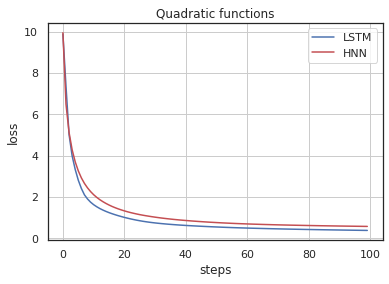

In [90]:
plt.plot(np.mean(fit_data[:,:,0], axis=0), color='b', label='LSTM')
plt.plot(np.mean(fit_data[:,:,1], axis=0), color='r', label='HNN')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Quadratic functions')
plt.legend()
plt.grid()
plt.show()

# MNIST

In [91]:
class MNISTLoss:
    def __init__(self, training=True):
        dataset = datasets.MNIST(
            '/home/chenwy/mnist', train=True, download=True,
            transform=torchvision.transforms.ToTensor()
        )
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]

        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))

        self.batches = []
        self.cur_batch = 0
        
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

class MNISTNet(MetaModule):
    def __init__(self, layer_size=20, n_layers=1, **kwargs):
        super().__init__()

        inp_size = 28*28
        self.layers = {}
        for i in range(n_layers):
            self.layers[f'mat_{i}'] = MetaLinear(inp_size, layer_size)
            inp_size = layer_size

        self.layers['final_mat'] = MetaLinear(inp_size, 10)
        self.layers = nn.ModuleDict(self.layers)

        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()

    def all_named_parameters(self):
        return [(k, v) for k, v in self.named_parameters()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))

        cur_layer = 0
        while f'mat_{cur_layer}' in self.layers:
            inp = self.activation(self.layers[f'mat_{cur_layer}'](inp))
            cur_layer += 1

        inp = F.log_softmax(self.layers['final_mat'](inp), dim=1)
        l = self.loss(inp, out)
        return l

In [ ]:
loss_LSTM, MNIST_optimizer_LSTM = fit_optimizer(MNISTLoss, MNISTNet, unroll=20, optim_it=100, lr=0.001, out_mul=0.1, preproc=True, n_tests=5, n_epochs=50)

In [ ]:
loss_HNN, MNIST_optimizer_HNN = fit_optimizer_HNN(MNISTLoss, MNISTNet, unroll=1, optim_it=1, lr=0.001, out_mul=0.1, n_tests=5, n_epochs=10)

In [22]:
print('Best loss of LSTM = ', loss_LSTM)
print('Best loss of HNN = ', loss_HNN)

Best loss of LSTM =  2.3219166
Best loss of HNN =  2.3425555


In [24]:
fit_data = np.zeros((100, 100, 2))
np.random.seed(0)

opt = w(Optimizer(preproc=True))
opt.load_state_dict(MNIST_optimizer_LSTM)
fit_data[:, :, 0] = np.array([do_fit(opt, None, MNISTLoss, MNISTNet, 1, 100, 200, out_mul=0.1, should_train=False) for _ in range(100)])
opt = w(Optimizer_HNN())
opt.load_state_dict(MNIST_optimizer_HNN)
fit_data[:, :, 1] = np.array([do_fit_HNN(opt, None, MNISTLoss, MNISTNet, 1, 100, 200, out_mul=0.001, should_train=False) for _ in range(100)])

In [ ]:
plt.plot(np.mean(fit_data[:,:,0], axis=0), color='b', label='LSTM')
plt.plot(np.mean(fit_data[:,:,1], axis=0), color='r', label='HNN')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST')
plt.legend()
plt.grid()
plt.show()